# Electronic Component Classifier

## Import Libraries

In [1]:
import numpy as np #to do array operations
import matplotlib.pyplot as plt #to show image
import os #to iterate through directories and join paths
import cv2 #to do image operations
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import sklearn
from sklearn.model_selection import train_test_split
import copy
import scikitplot
from scikitplot.metrics import plot_confusion_matrix
import random
import shutil


#data directory
datadir = os.getcwd()


#if single image: insert image name <-------------------- SINGLE IMAGE INPUT

image_name = None #enter image name
#example: image_name = 'chips (1)'
single_image = [f'{image_name}.jpg', 'acceptable']



#categories
categories = ['acceptable', 'faulty']

*For single images, add name and class to the variable 'single_image' above*

## Collect Data (For folder of images)
* Note: For the program to work, the folder/image must be in the same directory as the program file

In [2]:
# create function to pull all data

faulty_data = []
acceptable_data = []

def create_data():
    IMG_SIZE = 55
    for category in categories:
        path = os.path.join(datadir, category) 
        class_num = categories.index(category) #using index of categories list as class numbers
        if os.path.exists(path): #if a folder of images
            if category == 'acceptable':
                for img in os.listdir(path): #iterate through the images in the directory specified
                    try: #to avoid parsing through broken images
                        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) #convert img to grayscale
                        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) #normalise image
                        acceptable_data.append([img_array, class_num]) 

                    except Exception as e:
                        pass #skipping broken images (if any)
            else:
                for img in os.listdir(path): #iterate through the images in the directory specified
                    try: #to avoid parsing through broken images
                        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) #convert img to grayscale
                        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) #normalise image
                        faulty_data.append([img_array, class_num]) 

                    except Exception as e:
                        pass #skipping broken images (if any)
    
create_data()

## Perform Data Augmentation

Assumptions made: 
* Colour is not too important for this task (since RGB data is 3x the size of grayscale, converted colour map to grayscale)
* The faulty images are rotated 90, 180, 270 degrees clockwise from an acceptable image
* All images are somewhat centralized with no extreme cases that half the component is out of frame
* For single image input, the image is assumed to be acceptable (since it is not possible to transform faulty to acceptable)

Notes:
* For folder of images: Implemented functions for data augmentation, including image rotation and flipping
* For single image: imported ImageDataGenerator for data augmentation

In [3]:
# Data Augmentation
new_faulty = []
new_acceptable = []
rawdata = []

# image rotation function
def rotate(img, angle, rotPoint=None):
    height = img.shape[0]
    width = img.shape[1]
    dimensions = (width, height)
    
    if rotPoint is None:
        rotPoint = (width//2, height//2) #centrepoint
    
    rotMat = cv2.getRotationMatrix2D(rotPoint, -angle, 1.0)
    return cv2.warpAffine(img, rotMat, dimensions)

# image translation function
def translate(img, x,y):
    transMat = np.float32([[1,0,x], [0,1,y]])
    dimensions = (img.shape[1], img.shape[0])
    return cv2.warpAffine(img, transMat, dimensions)

# augment faulty data function
def create_newfaulty(dataset):
    for i in range(len(dataset)):
        # image flipping (horizontally)
        img1= cv2.flip(dataset[i][0],1)
        # image flipping (vertically)
        img2= cv2.flip(dataset[i][0],0)
        # image flipping (both horizontally & vertically)
        img3= cv2.flip(dataset[i][0],-1)
        new_faulty.append([img1,1])
        new_faulty.append([img2,1])
        new_faulty.append([img3,1])
        
        #to avoid adding acceptable images
        if dataset[i][1] != 0:
            for j in range(1,10):
                x1,y1 =-j ,0
                x2,y2 = j ,0
                x3,y3 = 0, j
                x4,y4 = 0,-j
                #image translation
                img4= translate(dataset[i][0], x1, y1)
                img5= translate(dataset[i][0], x2, y2)
                img6= translate(dataset[i][0], x3, y3)
                img7= translate(dataset[i][0], x4, y4)
                new_faulty.append([img4,1])
                new_faulty.append([img5,1])
                new_faulty.append([img6,1])
                new_faulty.append([img7,1])
        # image right-angle rotation
        img8 = rotate(dataset[i][0], 90)
        new_faulty.append([img8,1])
    random.shuffle(new_faulty)


# augment acceptable data function
def create_newacceptable(dataset):
    for i in range(1,10):
        x1,y1 =-i ,0
        x2,y2 = i ,0
        x3,y3 = 0, i
        x4,y4 = 0,-i
        x5,y5 = i,i
        x6,y6 = -i,-i
        x7,y7 = i, -i
        for j in range(len(dataset)):
            img1 = translate(dataset[j][0],x1,y1)
            img2 = translate(dataset[j][0],x2,y2)
            img3 = translate(dataset[j][0],x3,y3)
            img4 = translate(dataset[j][0],x4,y4)
            img5 = translate(dataset[j][0],x5,y5)
            img6 = translate(dataset[j][0],x6,y6)
            img7 = translate(dataset[j][0],x7,y7)
            new_acceptable.append([img1,0])
            new_acceptable.append([img2,0])
            new_acceptable.append([img3,0])
            new_acceptable.append([img4,0])
            new_acceptable.append([img5,0])
            new_acceptable.append([img6,0])
            new_acceptable.append([img7,0])
    random.shuffle(new_acceptable)



# overall data augmentation function
def data_augmentation():
    #if folder of images
    if acceptable_data: 
        create_newfaulty(faulty_data) #create faulty images with faulty data
        create_newfaulty(acceptable_data) #create faulty images with acceptable data
        new_faulty.extend(faulty_data) #add original faulty images

        create_newacceptable(acceptable_data) #augment existing acceptable data
        new_acceptable.extend(acceptable_data) #add exisiting acceptable data
        
    #if single image  
    elif single_image[1] != None: 
        IMG_SIZE = 55
        
        datagen_acceptable = ImageDataGenerator(rotation_range=0, width_shift_range = 0.2, height_shift_range=0.2, 
                                     shear_range=0.2, zoom_range=0.2, horizontal_flip = False, fill_mode= 'nearest')
        datagen_faulty = ImageDataGenerator(rotation_range=0, width_shift_range = 0.2, height_shift_range=0.2,
                                     shear_range=0.2, zoom_range=0.2, horizontal_flip = True,vertical_flip=True, fill_mode= 'nearest')
        
        
        #convert single image into array
        pic_array = cv2.imread(single_image[0], cv2.IMREAD_GRAYSCALE)
        pic_array = cv2.resize(pic_array, (IMG_SIZE, IMG_SIZE))
        pic_array = img_to_array(pic_array)
        
        #transform single image into faulty image
        faulty_pic_array = rotate(pic_array, 90)
        faulty_pic_array = img_to_array(faulty_pic_array)
        
        #ensure image is of dim=4 before passing into ImageDataGenerator
        acceptable_pic_array = pic_array.reshape((1,) + pic_array.shape)
        faulty_pic_array = faulty_pic_array.reshape((1,) + faulty_pic_array.shape)
        
        #create folders for generated acceptable and faulty images
        if os.path.exists('generated_acceptable') or os.path.exists('generated_faulty'):
            shutil.rmtree('generated_acceptable')
            shutil.rmtree('generated_faulty')
        os.mkdir('generated_acceptable')
        os.mkdir('generated_faulty')
        
        #data augmentation
        count1 = 0
        for batch in datagen_acceptable.flow(acceptable_pic_array, batch_size = 1, save_to_dir = datadir + '/generated_acceptable/', save_prefix= 'acceptable', save_format='jpeg'):
            count1+=1
            if count1 >500:
                break
        count2 = 0        
        for batch in datagen_faulty.flow(faulty_pic_array, batch_size = 1, save_to_dir = datadir + '/generated_faulty/', save_prefix= 'faulty', save_format='jpeg'):
            count2+=1
            if count2 >500:
                break
        
        #Add acceptable and faulty images into separate lists
        path_acceptable = datadir + '/generated_acceptable/'
        path_faulty = datadir + '/generated_faulty/'
        for img in os.listdir(path_acceptable):
            img_array = cv2.imread(os.path.join(path_acceptable, img), cv2.IMREAD_GRAYSCALE) #convert img to grayscale
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) #normalise image
            new_acceptable.append([img_array, 0])
        
        for img in os.listdir(path_faulty):
            img_array = cv2.imread(os.path.join(path_faulty,img), cv2.IMREAD_GRAYSCALE) #convert img to grayscale
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) #normalise image
            new_faulty.append([img_array, 1])
            

            
data_augmentation()


# combine faulty and acceptable data

#if imbalanced data
if len(new_acceptable)>len(new_faulty) or len(new_acceptable)<len(new_faulty):

    #ensure balanced dataset
    val = min(len(new_acceptable), len(new_faulty))
    new_acceptable = new_acceptable[:val]
    new_faulty = new_faulty[:val]

    #combine
    rawdata.extend(new_faulty)
    rawdata.extend(new_acceptable)
else:
    rawdata.extend(new_faulty)
    rawdata.extend(new_acceptable)

*To ensure balanced dataset, the data augmentation provides enough data samples so that dataset can be trimmed if there was a case of more acceptable/faulty images. This results in a 50:50 ratio for the classes.*

## Splitting Data Into Training And Test Sets

In [4]:
# Prepare Training and Test data

if rawdata:
    data = copy.deepcopy(rawdata)

    X = [] # feature set
    y = [] # label

    for features, label in data:
        X.append(features)
        y.append(label)

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42) 
    #Note: '0': acceptable, '1': faulty


    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    #reshape tensor
    X_train2 = X_train.reshape(-1, 55,55,1)
    X_test2 = X_test.reshape(-1, 55,55,1)

    #normalize data before fitting the model
    X_train2 = X_train2/255
    X_test2 = X_test2/255


## Implementation of CNN using Keras

* Implemented a 3-layer Keras CNN

In [5]:
#############################################
# implementing Convolutional Neural Network #
#############################################

# build model

model = Sequential()

# 1st layer: Convolution layer
model.add(Conv2D(64, (3,3), input_shape = X_train2.shape[1:]))

# 1b layer: Activation layer
model.add(Activation('relu'))

# 1c layer: Pooling layer
model.add(MaxPooling2D(pool_size = (2,2)))

# repeat layer: 2nd layer
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# second last layer: Flatten layer (due to ConV layer being 2-D and Dense layer needing 1-D)
model.add(Flatten())

# final layer: Dense Layer
model.add(Dense(64))
model.add(Activation('relu'))


# output layer
model.add(Dense(1)) #1 node
model.add(Activation('sigmoid'))


early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0.1, verbose = 1)

model.compile(loss='binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

## Fit Model with Training Data

###### Note:
* Previously fit model with 5 epochs and got 100% accuracy
* Implemented early stopping to ensure model does not overfit on training set
* Stopped at 4 epochs with 99.6% accuracy as 100% implies overfitting on training set (perfect fit)
* Reducing performance on training set ensures better generalization (which is the goal of classification)

In [6]:
# fit the model with the training data
history = model.fit(X_train2, y_train, batch_size=32, epochs=10, validation_split=0.1, callbacks = [early_stopping]) 

Epoch 1/10
129/129 [==============================] - 10s 70ms/step - loss: 0.3889 - accuracy: 0.7980 - val_loss: 0.0275 - val_accuracy: 0.9956
Epoch 2/10
129/129 [==============================] - 9s 67ms/step - loss: 0.0372 - accuracy: 0.9902 - val_loss: 0.0165 - val_accuracy: 1.0000
Epoch 3/10
129/129 [==============================] - 8s 66ms/step - loss: 0.0209 - accuracy: 0.9956 - val_loss: 0.0269 - val_accuracy: 0.9956
Epoch 4/10
129/129 [==============================] - 9s 68ms/step - loss: 0.0151 - accuracy: 0.9963 - val_loss: 0.0052 - val_accuracy: 0.9978
Epoch 00004: early stopping


## Predict with Trained Model

In [7]:
# calculate validation loss and accuracy
val_loss, val_acc = model.evaluate(X_test2, y_test)

print(val_loss, val_acc)

36/36 [==============================] - 0s 12ms/step - loss: 0.0044 - accuracy: 1.0000
0.004350938834249973 1.0


In [8]:
# Predict with model
predictions = model.predict(X_test2)

def display_results(rows, cols, predictions, test_set):
    pred = np.array(predictions)
    labels = (pred >0.5).astype(np.int)
    fig = plt.figure(figsize=(8,8))
    for i in range(1,cols*rows+1):
        fig.add_subplot(rows, cols,i)
        plt.title(f"{'acceptable' if labels[i][0]==0 else 'faulty'}")
        plt.imshow(test_set[i], cmap='gray')
    plt.show()

## Detection Report
Includes:
* Display of images with predicted labels (first 15 test images)
* Model Accuracy Plot
* Model Loss Plot 
* Confusion Matrix

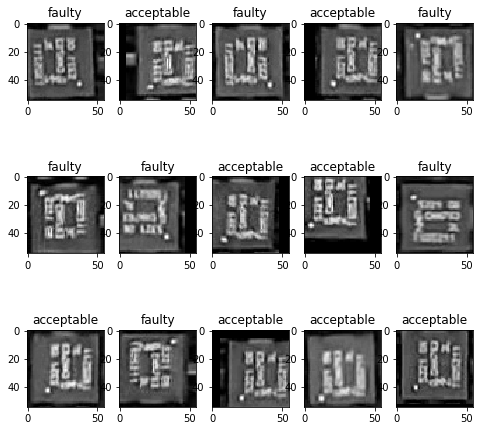

In [9]:
display_results(3,5, predictions, X_test)

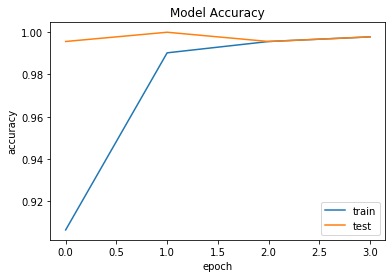

In [10]:
# plot Keras' builtin accuracy metric
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'lower right')
plt.show()

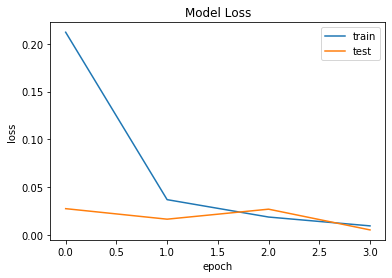

In [11]:
# plot Keras' builtin loss metric
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

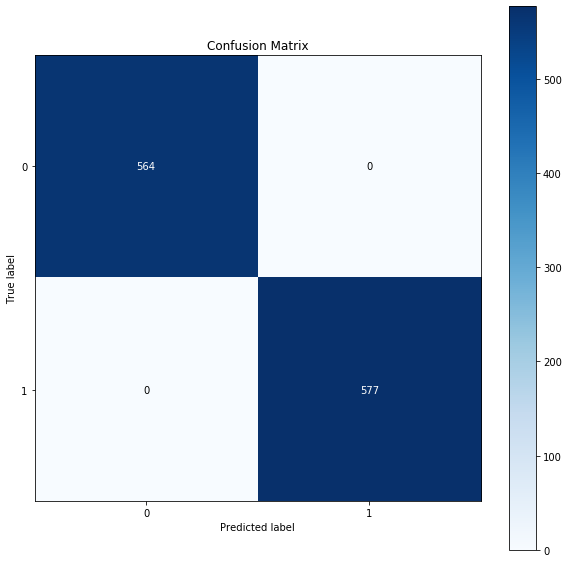

In [12]:
# plot confusion matrix
pred = np.array(predictions)
labels = (pred >0.5).astype(np.int)
y_pred_class = labels.tolist()
y_pred_class = [i for sublist in y_pred_class for i in sublist]

fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(y_test, y_pred_class, ax=ax)

In [14]:
# save the model
model.save('EC_Classifier.model')

INFO:tensorflow:Assets written to: EC_Classifier.model/assets
